In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
from sklearn.model_selection import TimeSeriesSplit

In [4]:
import os
os.listdir('data')

['202005_petroleo_cnmc.xlsx',
 'cnmc_goa_gna.xlsx',
 'cnmc_prov_month_prices.xlsx',
 'Estadisticas_petroleo_mayo_2020.xlsx',
 'FB5C7D00',
 'out']

In [5]:
INPATH = "data/"
INFILE1 = "cnmc_goa_gna.xlsx"

In [6]:
OUTPATH = 'data/out/'
OUTFILE = 'cons_gna95_test_naive.xlsx'

In [7]:
data = pd.read_excel(INPATH+INFILE1, parse_dates=['Date'], index_col='Date')
data.index.freq = 'MS'
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158 entries, 2007-01-01 to 2020-02-01
Freq: MS
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cons_GOA     158 non-null    float64
 1   cons_GNA95   158 non-null    float64
 2   cons_GNA98   158 non-null    float64
 3   spot_GOA     158 non-null    float64
 4   spot_GNA     158 non-null    float64
 5   spot_Brent   158 non-null    float64
 6   price_GOA    158 non-null    float64
 7   price_GNA95  158 non-null    float64
 8   price_GNA98  158 non-null    float64
 9   split        158 non-null    object 
dtypes: float64(9), object(1)
memory usage: 13.6+ KB


In [8]:
cols = data.select_dtypes(include='number').columns.tolist()

In [9]:
re_cons = re.compile(r'^cons_')
re_spot = re.compile(r'^spot_')
re_price = re.compile(r'^price_')

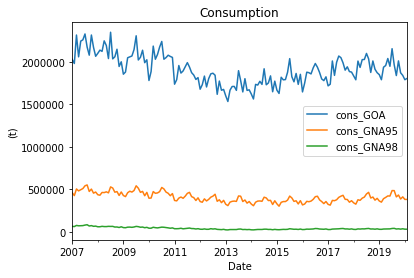

In [10]:
ax = data.filter(regex=re_cons).plot(title='Consumption')
ax.set_ylabel('(t)')
plt.show()

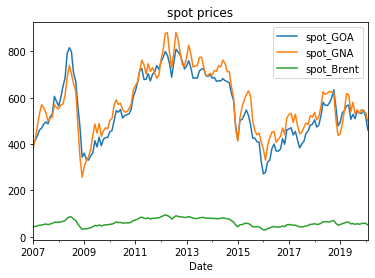

In [11]:
data.filter(regex=re_spot).plot(title='spot prices')
ax.set_ylabel('($/t)')
plt.show()

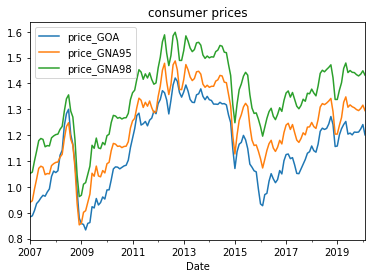

In [12]:
data.filter(regex=re_price).plot(title='consumer prices')
ax.set_ylabel('(€/l)')
plt.show()

# Basic feature engineering

In [13]:
cols_pct_change = []
for col in cols:
    data[f'{col}_pct_change1'] = data[col].pct_change()
    data[f'{col}_diff1'] = data[col].diff()
    data[f'{col}_diff1_sdiff12'] =  data[f'{col}_diff1'].diff(12)
    
    data[f'{col}_mave3'] = data[col].rolling(3).mean()
    data[f'{col}_vs_mave3'] = data[col]- data[f'{col}_mave3']
    
    data[f'{col}_pct_change1_lag1'] = data[f'{col}_pct_change1'].shift(1)
    data[f'{col}_diff1_lag1'] = data[f'{col}_diff1'].shift(1)
    
    
data['yr'] = data.index.year
data['qtr'] = data.index.quarter
data['mon'] = data.index.month
data['week'] = data.index.week

# Seasonal and Trend Decomposition

In [14]:
seas_period = 12
seas_models = {}
for col in cols:
    # Fit decomposition model with train data
    seas_add = seasonal_decompose(data.loc[data['split'] == 'train', col], period=seas_period, model='additive')
    seas_models[col] = seas_add
    seas_comp = seas_add.seasonal.copy()
    seas_comp.index = seas_comp.index.month
    # Index by seasonal period
    seas_dict = seas_comp[:seas_period].to_dict()
    data[f'{col}_seas_comp'] = data['mon'].replace(seas_dict)
    data[f'{col}_seas_adj'] = data[col] -  data[f'{col}_seas_comp']
    # Compute other features
    data[f'{col}_seas_adj_diff1'] =  data[col].diff()
    data[f'{col}_seas_adj_pct_change1'] = data[f'{col}_seas_adj'].pct_change()
    data[f'{col}_seas_adj_pct_change1_lag1'] = data[f'{col}_seas_adj_pct_change1'].shift(1)
    
    data[f'{col}_seas_adj_mave{seas_period}'] = data[col].rolling(seas_period).mean()
    data[f'{col}_seas_adj_vs_mave{seas_period}'] = data[col] - data[f'{col}_seas_adj_mave{seas_period}']

In [15]:
data.isna().sum(axis=0)

cons_GOA                                  0
cons_GNA95                                0
cons_GNA98                                0
spot_GOA                                  0
spot_GNA                                  0
                                         ..
price_GNA98_seas_adj_diff1                1
price_GNA98_seas_adj_pct_change1          1
price_GNA98_seas_adj_pct_change1_lag1     2
price_GNA98_seas_adj_mave12              11
price_GNA98_seas_adj_vs_mave12           11
Length: 140, dtype: int64

## Autorregressive model features and targets

In [16]:
ar_features = [f'cons_GNA95_pct_change1', 'price_GNA95_pct_change1']
for col in ['cons_GNA95_pct_change1']:
    for tau in range(1, 3+1):
        data[f'{col}_lag{tau}'] = data[f'{col}'].shift(tau)
        ar_features.append(f'{col}_lag{tau}')

In [17]:
data['x_mon_seas_cos'] = np.cos(data['mon']*2*np.pi/12)
data['x_mon_seas_sin'] = np.sin(data['mon']*2*np.pi/12)
ar_features = ar_features + ['x_mon_seas_cos', 'x_mon_seas_sin']

In [18]:
data['cons_GNA95_pct_change1_t1'] = data['cons_GNA95_pct_change1'].shift(-1)

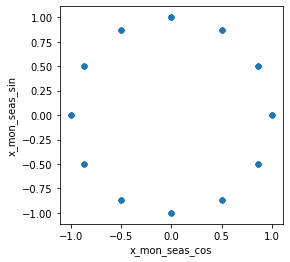

In [19]:
data.plot.scatter(x='x_mon_seas_cos', y='x_mon_seas_sin',figsize=(4,4))
plt.show()

In [20]:
data = data[13:].copy()

In [21]:
data.isna().sum(axis=0).sum()

1

In [33]:
data_train = data.loc[data['split']=='train'].copy()
data_test = data.loc[data['split']=='test'].copy()

# Benchmark: Naive

In [49]:
select_cols = ['model', 'cons_GNA95', 'p_cons_GNA95']

p_gna95_test = data_test[['cons_GNA95']].copy()

p_gna95_test['p_cons_GNA95'] = data_test['cons_GNA95'].shift(1)
p_gna95_test['p_cons_GNA95'].iloc[0] = data_train['cons_GNA95'].iloc[-1]
p_gna95_test['model'] = 'naive'
p_gna95_test.index = p_gna95_test.index.date

p_gna95_test[select_cols].to_excel(OUTPATH + OUTFILE, index_label='Date')